In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Get Data

In [2]:
df = pd.read_pickle('graphics_card_data.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7406 entries, 0 to 7405
Data columns (total 7 columns):
condition               7405 non-null object
manufacturer            5136 non-null object
memory_type             5388 non-null object
sold_price              7406 non-null float64
memory_size_kb          7406 non-null float64
sold_date               7406 non-null datetime64[ns]
bit_coin_close_price    7406 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 462.9+ KB


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


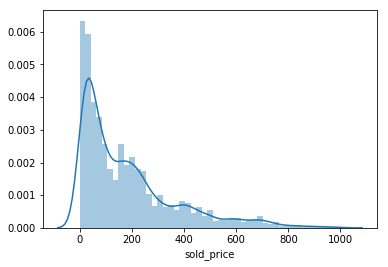

In [4]:
sns.distplot(df['sold_price'])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


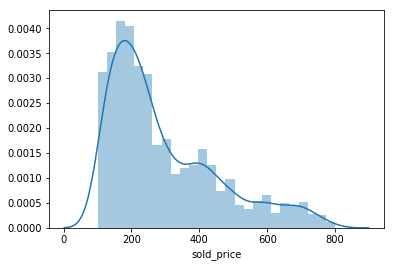

In [5]:
#very skewed..try to get a better subset?
sns.distplot(df[(df['sold_price'] > 100) & (df['sold_price'] < 800)]['sold_price'])

In [6]:
#see how many rows we'd have left if we did that
len(df[(df['sold_price'] > 100) & (df['sold_price'] < 800)])

3920

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


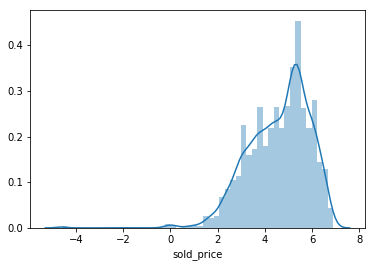

In [7]:
#maybe log transform?
sns.distplot(np.log(df['sold_price']))
# df['log_sold_price'] = np.log(df['sold_price'])
# df['log_memory_size_kb'] = np.log(df['memory_size_kb'])

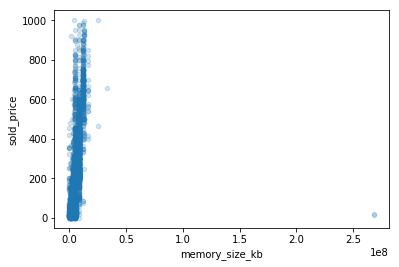

In [8]:
#see relationship vs memory_size and sold_price
df.plot.scatter('memory_size_kb', 'sold_price', alpha = 0.2)

In [9]:
#seems like there's an outlier... let's see what's going on there
outlier = df[(df['memory_size_kb'] > (2*(10**8)))& (df['sold_price'] < 200)]
outlier

,condition,manufacturer,memory_type,sold_price,memory_size_kb,sold_date,bit_coin_close_price
4920,Used,None,None,15.5,268435456.0,2018-06-20,6758.38
6131,Used,None,None,18.0,268435456.0,2018-06-12,6548.33


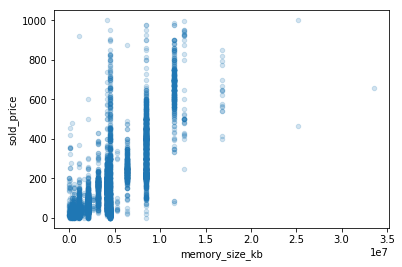

In [10]:
#2.5e8kb is ~250gb, but the largest memory for graphics cards right now are ~32gb, so let's drop this one
df = df.drop(outlier.index)
df.plot.scatter('memory_size_kb', 'sold_price', alpha = 0.2)

### much better. still a few outliers, however they are within 32gb, so let's keep them for now

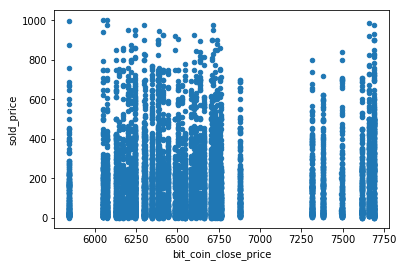

In [11]:
#see relationship between close price and sold_price
df.plot.scatter('bit_coin_close_price', 'sold_price')

#### not much going on here

In [12]:
#let's create some time series!
#look at mean sold_price over time and close price over time
def get_mean_sold_price_ts(df):
    ts_mean_sold_price = df[['sold_date','sold_price']].groupby('sold_date').mean()
    ts_mean_sold_price.rename(columns={'sold_price':'mean_sold_price'}, inplace=True)
    return ts_mean_sold_price
ts_mean_sold_price = get_mean_sold_price_ts(df)
ts_mean_sold_price.head()

,mean_sold_price
sold_date,
2018-06-04,107.663333
2018-06-05,133.990577
2018-06-06,226.344593
2018-06-07,270.731295
2018-06-08,172.333333


In [13]:
ts_close_price = df[['sold_date','bit_coin_close_price']].groupby('sold_date').first()
ts_close_price.head()

,bit_coin_close_price
sold_date,
2018-06-04,7490.59
2018-06-05,7616.89
2018-06-06,7655.98
2018-06-07,7688.00
2018-06-08,7616.10


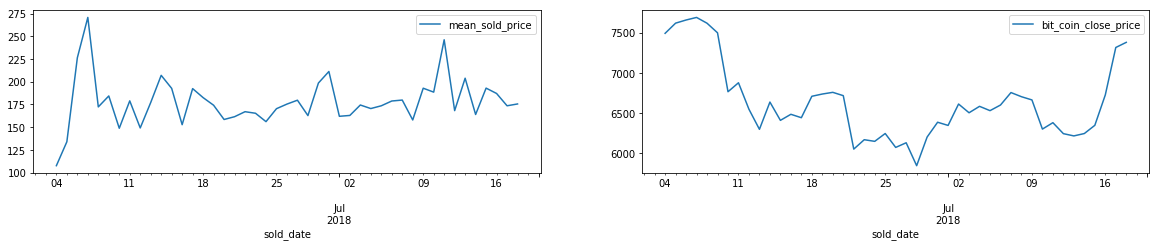

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,3))
ts_mean_sold_price.plot(ax = axes[0])
ts_close_price.plot(ax = axes[1])


hard to tell from this... need to look into this a bit more, but might be interesting

# Create Holdout Set

In [15]:
#df_train, df_holdout = train_test_split(df, test_size=0.1, random_state=42)
cut_off = df['sold_date'].max() - pd.Timedelta('7D')
df_train = df[df['sold_date'] < cut_off]
df_holdout = df[df['sold_date'] >= cut_off]
df_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 7 columns):
condition               1459 non-null object
manufacturer            1008 non-null object
memory_type             1040 non-null object
sold_price              1460 non-null float64
memory_size_kb          1460 non-null float64
sold_date               1460 non-null datetime64[ns]
bit_coin_close_price    1460 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 91.2+ KB


# Baseline

In [16]:
#baseline model & OLS regression summary stats
X=df_train['memory_size_kb']

y=df_train['sold_price']

def get_ols(X,y):
    model = sm.OLS(y,sm.add_constant(X))
    results = model.fit()
    return results
ols_base = get_ols(X,y)
ols_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                 1.027e+04
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        07:33:38   Log-Likelihood:                -36511.
No. Observations:                5944   AIC:                         7.303e+04
Df Residuals:                    5942   BIC:                         7.304e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -21.1578      2.482     -8.524      0.000     -26.024     -16.292
memory_size_kb  4.668e-05   4.61e-07    101.332      0.000    4.58e-05    4.76e-05
==============================================================================
Omnibus:                     1899.218   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13479.993
Skew:                           1.341   Prob(JB):                         0.00
Kurtosis:                       9.873   Cond. No.                     9.16e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Baseline R^2 of 0.633! not bad!

In [17]:
def diagnostic_plot(x, y_train, y_pred):
    #actual vs pred
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.scatter(x,y, alpha=0.2)
    plt.scatter(x,y_pred)
    plt.title('Regression Fit')
    plt.xlabel('x')
    plt.ylabel('y')
    #residual
    plt.subplot(1,3,2)
    res = y-y_pred
    plt.scatter(y_pred,res,alpha=.1)
    plt.plot(np.linspace(0,1800,1000),np.linspace(0,0,1000))
    plt.title('Residual Plot')
    plt.xlabel('Predicted Value')
    plt.ylabel('Residual')
    #qq
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

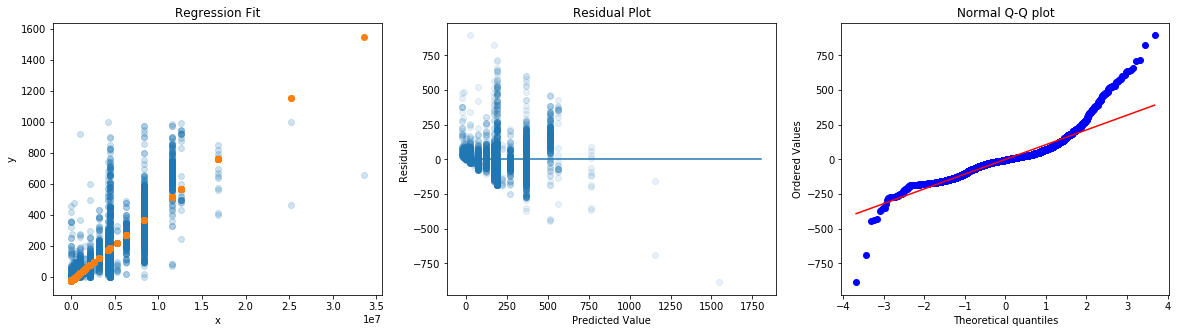

In [18]:
y_pred = ols_base.predict(sm.add_constant(X))
diagnostic_plot(df_train['memory_size_kb'], y, y_pred)

### looks like we might have some heteroskedasticity in the residual plot and maybe we have an exponential relationship with memory_size? let's check that out later

# Expanding Model

### let's add some mean daily sold price time lagged features

In [19]:
def add_mean_sold_lag(df, n):
    ts_mean_sold_price = get_mean_sold_price_ts(df)
    for i in range(n):
        ts_mean_sold_price['mean_sold_price_lag_{}'.format(i+1)] = ts_mean_sold_price['mean_sold_price'].shift(i+1)
    df_shifted = pd.merge(df, ts_mean_sold_price, left_on="sold_date", right_index=True)
    df_shifted.dropna(inplace=True)
    return df_shifted

In [20]:
df_train_lag = add_mean_sold_lag(df_train, 1)
df_train_lag.sample(1).sort_values("sold_date")

,condition,manufacturer,memory_type,sold_price,memory_size_kb,sold_date,bit_coin_close_price,mean_sold_price,mean_sold_price_lag_1
4449,Used,NVIDIA,DDR3,49.0,1048576.0,2018-06-23,6170.56,165.320863,167.040172


In [21]:

#let's compare scores!
base_x_cols = ['memory_size_kb']
y_col = ['sold_price']

y_train_base = df_train[y_col]
#base model
X_train_base = df_train[base_x_cols]
lm_base = LinearRegression()

#lagged mean_sold_price model
lag_x_cols = base_x_cols + [col for col in df_train_lag.columns if col.startswith('mean_sold_price_lag')]
X_train_lag = df_train_lag[lag_x_cols]
y_train_lag = df_train_lag[y_col]
lm_lag = LinearRegression()

base_r2 = np.mean(cross_val_score(lm_base,X_train_base, y_train_base, cv=5))
lag_r2 = np.mean(cross_val_score(lm_lag,X_train_lag,y_train_lag,cv=5))

model_scores = {
    'baselg': base_r2,
    'lag_lg_1': lag_r2
}
model_scores

{'baselg': 0.628469731596837, 'lag_lg_1': 0.6823972988707774}

### lagged model is better (higher r2)!

## let's checkout the relationship with condition

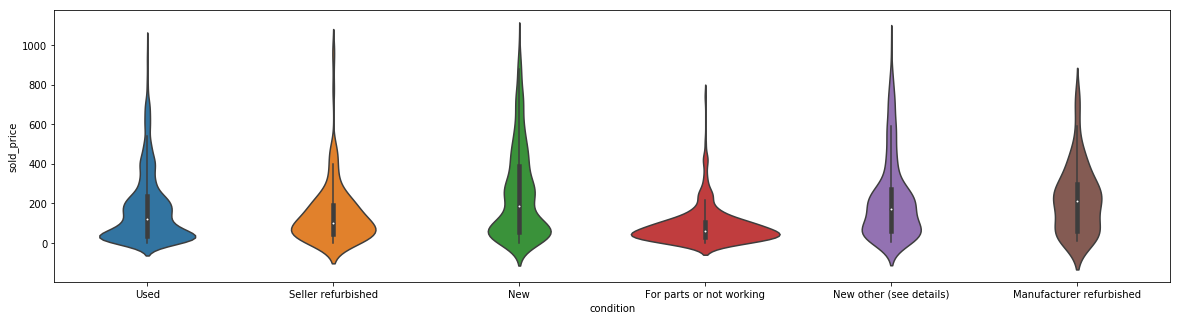

In [34]:
#look at relationship with condition
fig, ax = plt.subplots(figsize=(20,5))
sns.violinplot(ax = ax, data = df, x='condition',y='sold_price')

### this looks promising, let's test it out, as you can see the distribution for newer have higher prices and the refurbished vs seller refurbished have slightly lower and used and parts not working have the most lowest

In [23]:
def encode_condition_data(data):
    #encode categorical variables
    transformed_data = pd.get_dummies(data, columns=['condition'])
    return transformed_data
df_train_cond = encode_condition_data(df_train[['memory_size_kb','condition', 'sold_price']])
df_train_cond.head()

,memory_size_kb,sold_price,condition_For parts or not working,condition_Manufacturer refurbished,condition_New,condition_New other (see details),condition_Seller refurbished,condition_Used
1460,4.488604e+06,18.99,0,0,0,0,0,1
1461,4.194304e+06,48.99,0,0,1,0,0,0
1462,1.048576e+06,22.95,0,0,0,0,0,1
1463,2.097152e+06,30.00,0,0,0,0,0,1
1464,4.194304e+06,44.99,0,0,0,1,0,0


In [24]:
df_train_cond.corr()

,memory_size_kb,sold_price,condition_For parts or not working,condition_Manufacturer refurbished,condition_New,condition_New other (see details),condition_Seller refurbished,condition_Used
memory_size_kb,1.000000,0.795888,-0.005800,0.030292,0.096371,0.044536,-0.058989,-0.082522
sold_price,0.795888,1.000000,-0.107265,0.017513,0.136526,0.060086,-0.023015,-0.089266
condition_For parts or not working,-0.005800,-0.107265,1.000000,-0.021534,-0.080756,-0.057013,-0.033929,-0.311021
condition_Manufacturer refurbished,0.030292,0.017513,-0.021534,1.000000,-0.043399,-0.030639,-0.018234,-0.167145
condition_New,0.096371,0.136526,-0.080756,-0.043399,1.000000,-0.114903,-0.068380,-0.626825
condition_New other (see details),0.044536,0.060086,-0.057013,-0.030639,-0.114903,1.000000,-0.048276,-0.442533
condition_Seller refurbished,-0.058989,-0.023015,-0.033929,-0.018234,-0.068380,-0.048276,1.000000,-0.263357
condition_Used,-0.082522,-0.089266,-0.311021,-0.167145,-0.626825,-0.442533,-0.263357,1.000000


### condition_new has the strongest correlation

In [25]:
condition_columns = [col for col in df_train_cond.columns if col.startswith('condition')]
x_cond_cols = condition_columns + ['memory_size_kb']
X_cond_train = df_train_cond[x_cond_cols]
y_cond_train = df_train_cond[y_col]
ols_condition = get_ols(X_cond_train,y_cond_train)
ols_condition.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     1822.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        07:33:38   Log-Likelihood:                -36391.
No. Observations:                5944   AIC:                         7.280e+04
Df Residuals:                    5937   BIC:                         7.284e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                -22.5285      3.197     -7.046      0.000     -28.796     -16.261
condition_For parts or not working   -92.5629      6.722    -13.769      0.000    -105.741     -79.384
condition_Manufacturer refurbished    -8.2935     11.642     -0.712      0.476     -31.116      14.529
condition_New                         30.6339      4.236      7.231      0.000      22.329      38.939
condition_New other (see details)     19.0606      5.184      3.677      0.000       8.898      29.224
condition_Seller refurbished          28.7003      7.723      3.716      0.000      13.560      43.841
condition_Used                        -0.0669      3.041     -0.022      0.982      -6.029       5.895
memory_size_kb                      4.635e-05   4.55e-07    101.800      0.000    4.55e-05    4.72e-05
==============================================================================
Omnibus:                     1937.599   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14534.301
Skew:                           1.355   Prob(JB):                         0.00
Kurtosis:                      10.165   Cond. No.                     1.23e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### high cond. no. and small eigenvalues indiciate high collinearity, but that's expected due to the categorical variables.  The coefficients make intuitive sense, which is encouraging!
### let's go ahead and run this through our cv test

In [26]:
#let's add condition to the model_scores
lm_condition = LinearRegression()
cond_r2 = np.mean(cross_val_score(lm_condition,X_cond_train, y_cond_train, cv=5))
model_scores['cond_lg'] = cond_r2
model_scores

{'baselg': 0.628469731596837,
 'lag_lg_1': 0.6823972988707774,
 'cond_lg': 0.6425388185091739}

### r2 goes up to 0.643 with the conditions, so let's try with conditions and lag!


In [27]:
df_train_cond_lag = encode_condition_data(df_train_lag)
X_cond_lag_cols = condition_columns + lag_x_cols + ['memory_size_kb']
X_train_cond_lag = df_train_cond_lag[X_cond_lag_cols]
y_train_cond_lag = df_train_cond_lag['sold_price']
lm_cond_lag = LinearRegression()
cond_lag_r2 = np.mean(cross_val_score(lm_cond_lag, X_train_cond_lag, y_train_cond_lag, cv=5))
model_scores['cond_lag1_lg'] = cond_lag_r2
model_scores

{'baselg': 0.628469731596837,
 'lag_lg_1': 0.6823972988707774,
 'cond_lg': 0.6425388185091739,
 'cond_lag1_lg': 0.6965182860153825}

### r2 goes up to 0.697 with conditions and lagged mean sold price terms!

# Final testing

In [28]:
df_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 7 columns):
condition               1459 non-null object
manufacturer            1008 non-null object
memory_type             1040 non-null object
sold_price              1460 non-null float64
memory_size_kb          1460 non-null float64
sold_date               1460 non-null datetime64[ns]
bit_coin_close_price    1460 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 91.2+ KB


In [29]:
#let's do a final test on our hold out set!
def transform_df(df):
    df_lag = add_mean_sold_lag(df[['condition', 'memory_size_kb', 'sold_price', 'sold_date']],1)
    df_cond_lag = encode_condition_data(df_lag)
    #get columns
    condition_columns = [col for col in df_cond_lag.columns if col.startswith('condition')]
    lag_cols = [col for col in df_cond_lag.columns if col.startswith('mean_sold_price_lag')]
    x_cols = condition_columns + lag_cols + ['memory_size_kb']
    return (df_cond_lag[x_cols], df_cond_lag['sold_price'])
X,y = transform_df(df_holdout)
final_lgmodel = LinearRegression()
np.mean(cross_val_score(final_lgmodel,X,y, cv=5))

0.6452968777970047

~0.645 r2 on hold out!

In [30]:
fit_final = final_lgmodel.fit(X,y)
y_pred = fit_final.predict(X)

def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))
RMSE(y,y_pred)

103.52779053808415

RMSE of ~103.53, so predictions are off by approximately ~$103.53 on average

# Future Considerations
* Take a longer time period sample
* Incorporate time-lagged bitcoin and other crypto currency data
* encode and test manufacturer and memory_type
    * use lasso and ridge regression (regularization) to deal with collinearity of categorical variables?
* look at specific range of graphics cards that are used for mining, machine learning, gaming, etc.
* incorporate feature interactions
* use normalization with larger number of variables